# Competition 1, alternative approach for online augmentation

In [57]:
import os
import os.path
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.xception import preprocess_input

tfk = tf.keras
tfkl = tf.keras.layers
print(f"Tensorflow version = ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)


Tensorflow version =  2.10.0
Num GPUs Available:  1


Folders for execution in local environment or Kaggle

In [58]:
kaggle_dir = "/kaggle/input/competition" + '/training_data_final'
local_dir = os.getcwd() + '/training_data_final'


## Dataset creation and online augmentation

Dataset creation from training dataset folder

In [59]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
dir = local_dir

samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]

# for each species
for i in range(0, len(images_ind)):
    # for each image in every species folder
    for j in range(0, images_ind[i]):
        temp = Image.open(f'{dir}/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

# creation of augmented dataset
X = np.array(samples)  # dtype=np.float16
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

labels = ["Species1", "Species2", "Species3", "Species4",
          "Species5", "Species6", "Species7", "Species8"]


(3542, 96, 96, 3) (3542, 8)
uint8, uint8


Image data generators for online augmentation, with image random preprocessing and augmentation

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# custom pre-processing with random contrast, saturation and hue variables for more robustness
def preprocess_custom(image):
    image = tf.image.random_contrast(image, 0.99, 1.01)
    image = tf.image.random_saturation(image, 0.85, 1.15 )
    image = tf.image.random_hue(image, 0.1)
    return preprocess_input(image)

# train and validation data splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)

# training set generator
train_data_gen = ImageDataGenerator(rotation_range = 180,
                                    height_shift_range = 30,
                                    width_shift_range = 30,
                                    horizontal_flip = True,
                                    brightness_range = (0.7, 1.3),
                                    zoom_range = 0.2,
                                    fill_mode = 'reflect',
                                    featurewise_center=True, 
                                    featurewise_std_normalization=True,
                                    preprocessing_function = preprocess_custom
                                    )
# needed only if normalization is used
train_data_gen.fit(preprocess_input(X_train)) #Fit the training generator to the non augmented training set to learn mean and std

valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    featurewise_center=True, 
                                    featurewise_std_normalization=True
)
# needed only if normalization is used
valid_data_gen.fit(preprocess_input(X_train))

# eventually, the normalization of the images was not used in the final models

# when normalization is used
print(f"training dataset over the 3 channels: mean = {train_data_gen.mean}, st.deviation = {train_data_gen.std}")



training dataset over the 3 channels: mean = [[[-0.3036871  -0.251026   -0.29216886]]], st.deviation = [[[0.41566643 0.4204223  0.41138655]]]


Creation of the dataset variables from the generators, using the flow method. This method takes the images directly from the memory, instead of reading them off the disk

In [61]:

# Data generators flow from arrays structures
train_gen = train_data_gen.flow(x = X_train, y = y_train, batch_size = 64, seed=seed, shuffle=True)
valid_gen = valid_data_gen.flow(x = X_val, y = y_val, batch_size = 64, seed=seed, shuffle=False)

# Create Datasets objects from generators
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_signature=(
    tf.TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8), tf.TensorSpec(shape=(None, 8), dtype=tf.float32))
)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, output_signature=(
    tf.TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8), tf.TensorSpec(shape=(None, 8), dtype=tf.float32))
)
# repeat method is needed so that the images are processed infinitely, until training is finished
valid_dataset = valid_dataset.repeat()


Augmented samples: plotting some random images after augmentation, rescaling and normalization

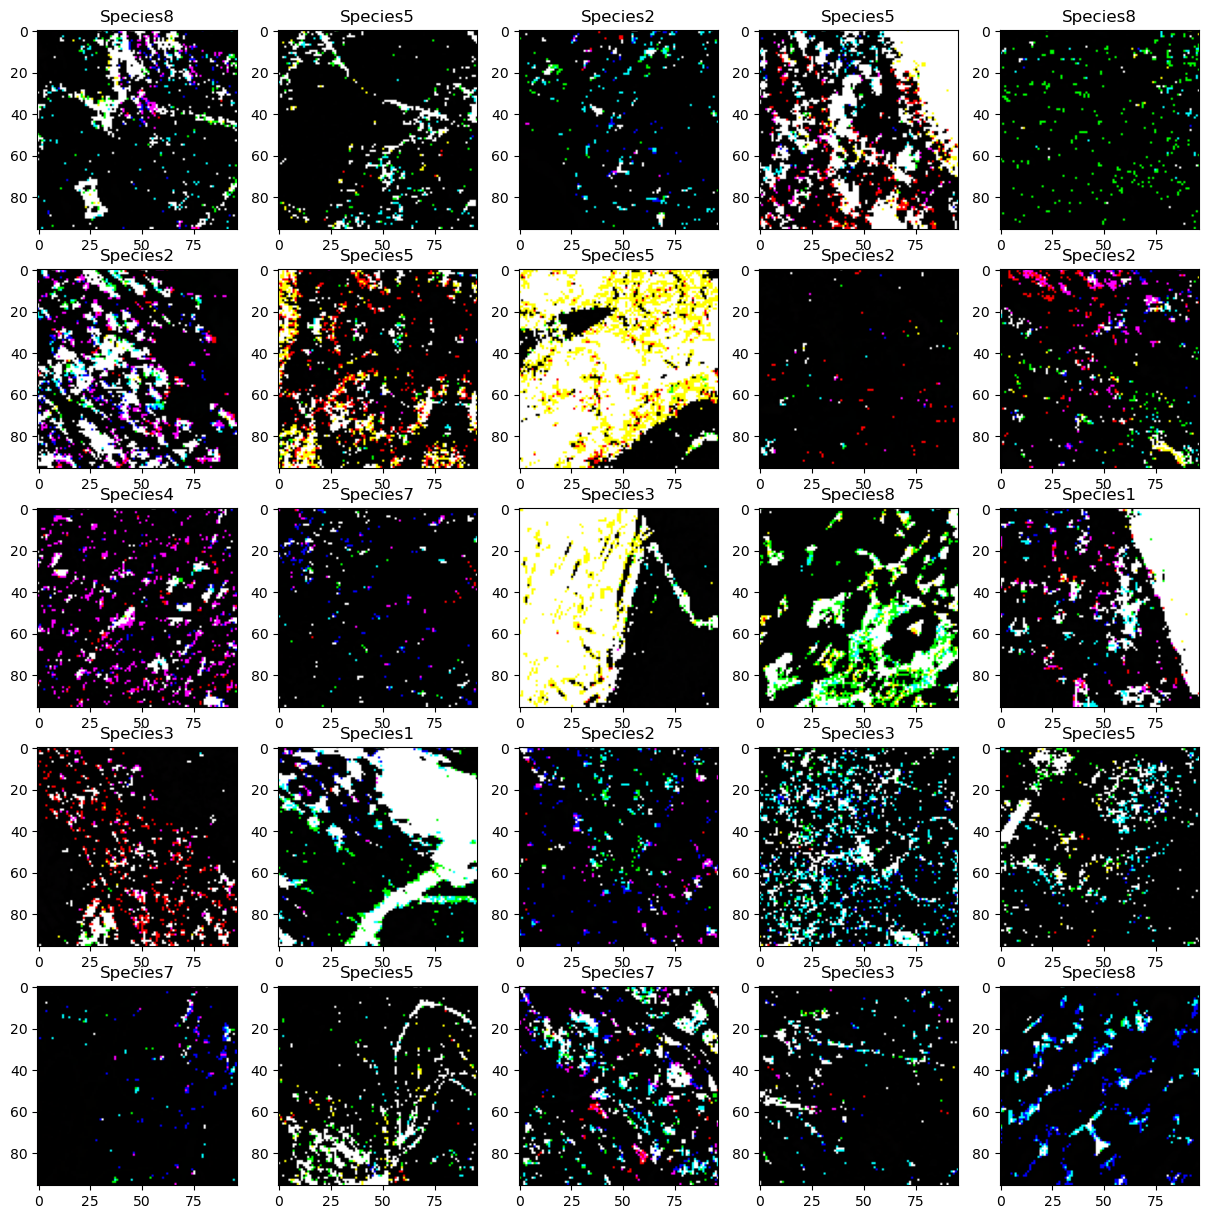

In [62]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for i in range(25):
    # plot raw pixel data
    image = train_dataset.take(1).as_numpy_iterator().next()
    ax[i//5, i % 5].imshow(image[0][0])
    ax[i//5, i % 5].set_title(labels[np.argmax(image[1][0])])


Classes distributions for weights computation using the scikit library

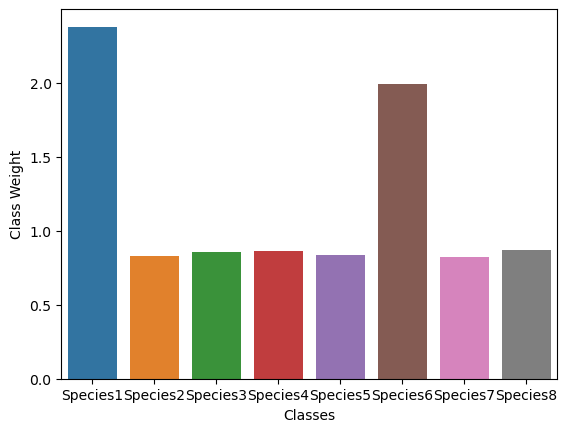

training set input shape (2833, 96, 96, 3) (2833, 8)
validation set input shape (709, 96, 96, 3) (709, 8)


In [63]:
# shows the new classes distribution
y_numeric = []
for v in y:
    y_numeric.append(np.argmax(v))

# computation of the new classes distribution according to a balanced average
class_weights_vect = class_weight.compute_class_weight(
    'balanced', classes=np.arange(8), y=y_numeric)
class_weights = dict(enumerate(class_weights_vect))

# shows the new classes distribution
plt.ylabel('Class Weight')
plt.xlabel('Classes')
sns.barplot(x=labels, y=class_weights_vect)
plt.show()


print(f"training set input shape", X_train.shape, y_train.shape)
print(f"validation set input shape", X_val.shape, y_val.shape)


## Model definition and training

Supernet model with images resizing (using bicubic interpolation) and a gloabl average pooling layer before the output dense layer

In [64]:
def build_supernet_model(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, weights="imagenet", input_shape=(299, 299, 3))

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(299, 299, interpolation="bicubic", name='resizing')(input_layer)

    # attach supernet to the input layer
    x = supernet(x)
    # add a global spatial average pooling layer
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(
        units=len(labels),
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer,
                      name='super_simonnet_v0')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


All layers of the supernet are made trainable

In [65]:
model = build_supernet_model(input_shape)
# Enable the tuning to the whole supernet
model.get_layer('xception').trainable = True

model.summary()


Model: "super_simonnet_v0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 8)                 16392     
                                                                 
Total params: 20,877,872
Trainable params: 20,823,344
Non-trainable params: 54,528
_________________________________________________________________


Callbacks for exponential decaying learning rate and the early stopping for regularization

In [66]:
# good GPU utilization on my machine with this batch size
batch_size = 64
epochs = 400

# exponential decay for the learning rate
initial_lr = 1e-4  # suggested 5e-5 for transfer learning applications


def scheduler(epoch, lr):
    if epoch <= 10:
        return initial_lr
    else:
        return max(initial_lr * tf.math.exp(- (epoch-10) / 10.0), 1e-5)


learning_rate_scheduler = tfk.callbacks.LearningRateScheduler(scheduler)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)


# Train the network
history = model.fit(x=train_dataset,
                    epochs=15,
                    steps_per_epoch=int(len(X_train)/batch_size),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,
                    callbacks=[learning_rate_scheduler, early_stop]
                    ).history


Epoch 1/15
44/44 [==============================] - 75s 2s/step - loss: 1.9296 - accuracy: 0.2806 - val_loss: 1.8936 - val_accuracy: 0.2539 - lr: 1.0000e-04
Epoch 2/15
44/44 [==============================] - 62s 1s/step - loss: 1.6592 - accuracy: 0.4092 - val_loss: 1.6320 - val_accuracy: 0.4443 - lr: 1.0000e-04
Epoch 3/15
44/44 [==============================] - 67s 2s/step - loss: 1.4909 - accuracy: 0.4550 - val_loss: 1.4398 - val_accuracy: 0.4781 - lr: 1.0000e-04
Epoch 4/15
44/44 [==============================] - 62s 1s/step - loss: 1.4107 - accuracy: 0.5049 - val_loss: 1.3515 - val_accuracy: 0.4824 - lr: 1.0000e-04
Epoch 5/15
44/44 [==============================] - 63s 1s/step - loss: 1.3564 - accuracy: 0.5291 - val_loss: 1.3903 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 6/15
44/44 [==============================] - 62s 1s/step - loss: 1.2767 - accuracy: 0.5338 - val_loss: 1.3682 - val_accuracy: 0.4739 - lr: 1.0000e-04
Epoch 7/15
44/44 [==============================] - 62s 1s

In [ ]:
model.save('supernet_simo_v1')


## Model evaluation

Training just for 15 epochs in the local machine, for demonstration purposes

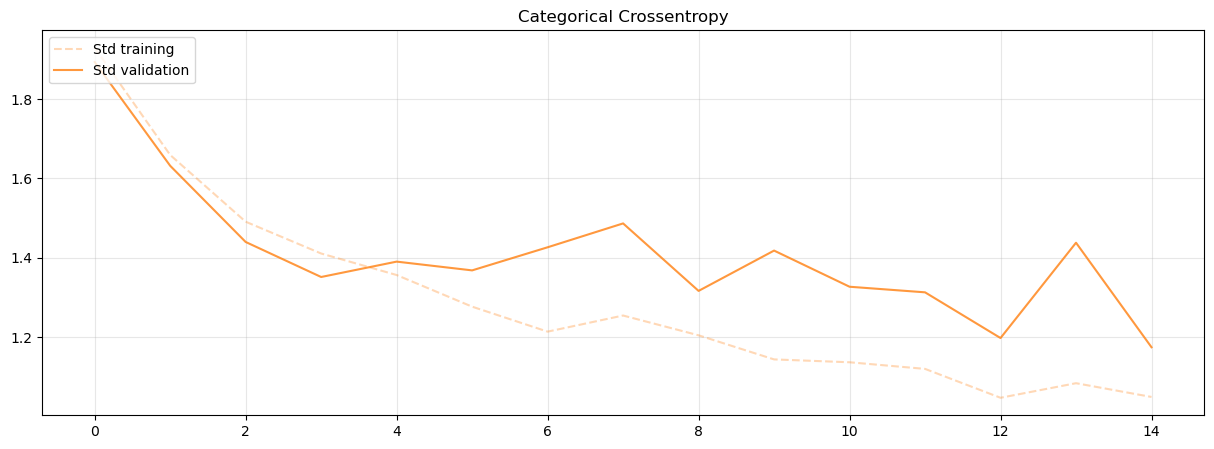

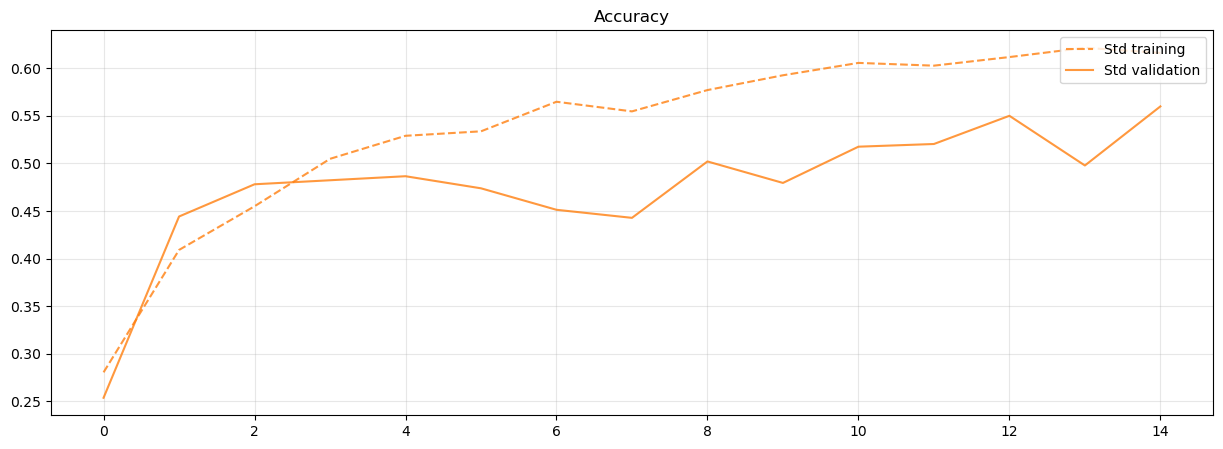

In [68]:
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='Std training',
         alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation',
         alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15, 5))
plt.plot(history['accuracy'], label='Std training',
         alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation',
         alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


Model statistics evaluation after 15 epochs of training

12/12 [==============================] - 7s 177ms/step
Accuracy: 0.5599
Precision: 0.5403
Recall: 0.5003
F1: [0.125  0.5    0.6491 0.534  0.708  0.3692 0.6444 0.4583]


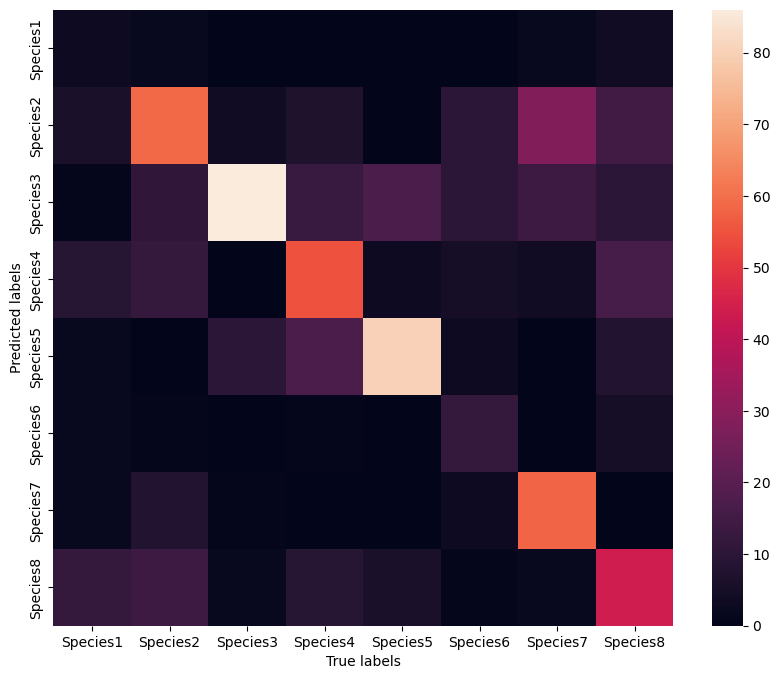

In [69]:
predictions = model.predict(valid_dataset, steps=len(valid_gen))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1),
                          np.argmax(predictions, axis=-1))
precision = precision_score(
    np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1),
                      np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1),
              np.argmax(predictions, axis=-1), average=None)
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


Plotting the F1 scores for each class, in order to evaluate the classes validation accuracy unbalancement 

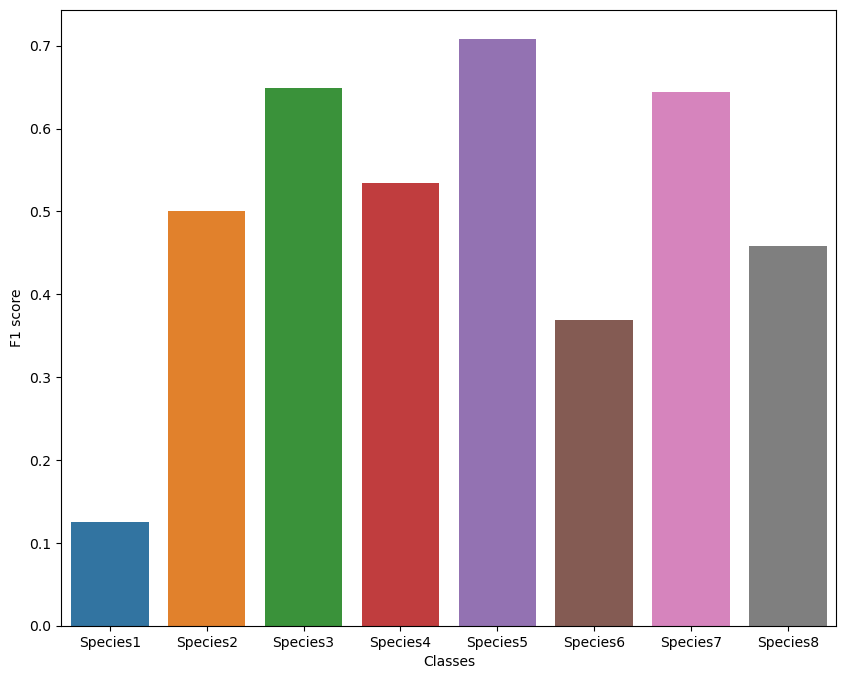

In [70]:
# plot F1 scores for each class
plt.figure(figsize=(10, 8))
plt.ylabel('F1 score')
plt.xlabel('Classes')
sns.barplot(x=labels, y=f1)
plt.show()


## Second part of model building

Our technique was training the supernet separately from the classifier network, composed of a dense layer, some dropout layers, and a skip connection between the global average pooling and the final output dense layer

In [71]:
def build_classifier_model_v1(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(include_top=False, input_shape=input_shape)

    # Recover previous weights
    supernet.set_weights(tfk.models.load_model('supernet_simo_v0').get_layer('xception').get_weights())

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = supernet(input_layer)

    x_gap = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x1 = tfkl.Dense(
        units=2048,
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed),
        name='dense1')(x_gap)
    x1 = tfkl.Dropout(0.2, seed=seed, name='dropout1')(x1)

    # Skip connection
    x = tfkl.Add()([x_gap, x1])

    x = tfkl.Dropout(0.3, seed=seed, name='dropout7')(x)

    output_layer = tfkl.Dense(
        units=len(labels),
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer,
                      name='super_simonnnet_classifier')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


The classifier network is composed of some trainable layers of the supernet, and the dense layers in the classifier network trainable as well

In [72]:
classifier_model = build_classifier_model_v1(input_shape)

# Use the supernet as a pretrained feature extraction net (and apply eventual fine tuning)
classifier_model.get_layer('xception').trainable = True
for i, layer in enumerate(classifier_model.get_layer('xception').layers[:-5]):
    layer.trainable = False
for i, layer in enumerate(classifier_model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)

classifier_model.summary()


Exception ignored in: <function UniquePtr.__del__ at 0x00000151AADEF5B0>
Traceback (most recent call last):
  File "d:\Programs\Anaconda\envs\anndl\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 70, in __del__
    def __del__(self):
KeyboardInterrupt: 


0 input_6 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_20 False
13 block2_pool False
14 batch_normalization_20 False
15 add_60 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_21 False
23 block3_pool False
24 batch_normalization_21 False
25 add_61 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_22 False
33 block4_pool False
34 batch_normalization_22 False
35 add_62 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5

Classifier network training

In [ ]:
classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,
                                          steps_per_epoch=int(len(X_train)/batch_size),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          class_weight=class_weights,
                                          callbacks=[early_stop,
                                                     learning_rate_scheduler]
                                          ).history


In [ ]:
classifier_model.save('supernet_simo_incresv2_tuned')


## Fine Tuned Model evaluation and statistics

In [ ]:


plt.figure(figsize=(15, 5))
plt.plot(classifier_history['loss'], label='Std training',
         alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(classifier_history['val_loss'],
         label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15, 5))
plt.plot(classifier_history['accuracy'], label='Std training',
         alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(classifier_history['val_accuracy'],
         label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


In [ ]:
predictions = classifier_model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1),
                      np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1),
                          np.argmax(predictions, axis=-1))
precision = precision_score(
    np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1),
                      np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1),
              np.argmax(predictions, axis=-1), average=None)
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


In [ ]:
# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(
    y_val, axis=-1), y_pred=np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
